## Image segmentation unet test - CareStart RDT

In [1]:
%matplotlib inline

In [2]:
import torch

In [3]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

In [4]:
path = Path.cwd()/'care456' #untar_data(URLs.CAMVID)
path.ls()

(#7) [Path('/home/ubuntu/unetseg/care456/images'),Path('/home/ubuntu/unetseg/care456/codes.txt'),Path('/home/ubuntu/unetseg/care456/labels'),Path('/home/ubuntu/unetseg/care456/valid.txt'),Path('/home/ubuntu/unetseg/care456/models'),Path('/home/ubuntu/unetseg/care456/export_project_2526009_2020-03-02-02-44-38'),Path('/home/ubuntu/unetseg/care456/.ipynb_checkpoints')]

In [5]:
fnames = get_image_files((path/'images'))

In [6]:
valid_fnames = (path/'valid.txt').read().split('\n')

In [7]:
def get_pixel_to_class(fnames, is_partial=True):  
    "Gather the codes from a list of `fnames`"
    vals = set()
    if is_partial:
        random.shuffle(fnames)
        fnames = fnames[:10]
    for fname in fnames:
        msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
        if val not in vals:
            vals.add(val)
    p2c = dict()
    for i,val in enumerate(vals):
        p2c[i] = val
    return p2c


In [8]:
def get_msk(fn, pix2class):
    fn = path/'labels'/f'{fn.stem}.png'
    msk = np.array(PILMask.create(fn))
    msk[msk > 1] = 0
    mx = np.max(msk)
    for i, val in enumerate(pix2class):
        msk[msk==pix2class[i]] = val
    return PILMask.create(msk)


In [9]:
p2c = get_pixel_to_class(fnames)

In [10]:
#def get_msk(fn):
#  fn = path/'label'/f'{fn.stem}.png'
#  msk = np.array(PILMask.create(fn))
#  msk[msk > 1] = 0
#  return PILMask.create(msk)

In [11]:
#mask = PILMask.create(get_msk(Path(valid_fnames[0])))
#mask.show(figsize=(5,5), alpha=.5)
#img.show(figsize=(5,5))

In [12]:
def ListSplitter(valid_items):
    def _inner(items):
        val_mask = tensor([o.name in valid_items for o in items])
        return [~val_mask,val_mask]
    return _inner

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [14]:
size = (171,228)

In [15]:
full_size=(352,456)

In [16]:
#get_y = lambda o: get_msk(o, p2c)



In [17]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=ListSplitter(valid_fnames),
                   get_y = lambda o: get_msk(o, p2c),  #get_y=lambda o: path/'labels'/f'{o.stem}.png',
                   batch_tfms=[*aug_transforms(size=(size)),  Normalize.from_stats(*imagenet_stats)])

dls = camvid.dataloaders(path/"images", bs=2)

In [18]:
dls = SegmentationDataLoaders.from_label_func(path, bs=2,
    fnames = get_image_files(path/"images"), 
    label_func = lambda o: path/'labels'/f'{o.stem}.png',                                     
    codes = codes,                         
    batch_tfms=[*aug_transforms(size=size),Normalize.from_stats(*imagenet_stats)])

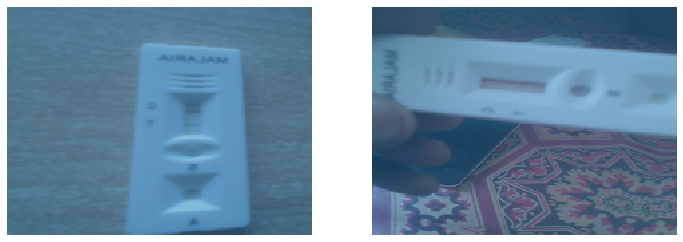

In [19]:
dls.show_batch(max_n=2, rows=1, figsize=(12, 8))

In [20]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
dls.vocab = codes

In [21]:
name2id = {v:k for k,v in enumerate(codes)}
#void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target # != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [29]:
name2id

{'background': 0, 'carestart': 1}

In [22]:
opt_func = partial(Adam, lr=3e-3, wd=0.01)#, eps=1e-8)

learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(axis=1), opt_func=opt_func, path=path, metrics=accuracy, #acc_camvid,
                     config = unet_config(norm_type=None), wd_bn_bias=True)

In [23]:
get_c(dls)

2

In [28]:
x,y = dls.one_batch()

In [31]:
x.shape

torch.Size([2, 3, 171, 228])

In [32]:
y.shape

torch.Size([2, 171, 228])

In [ ]:
x,y = dls.one_batch()

x.shape
torch.Size([2, 3, 171, 228])


y.shape
torch.Size([2, 171, 228])


In [25]:
lr= 8e-4
learn.freeze()

In [26]:
learn.fit_one_cycle(5, slice(lr), pct_start=0.9, wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.663077,0.484067,None,00:03


AssertionError: ==:
684
77976

## Data

In [30]:
fnames = get_image_files(path_img)
fnames[:3]

NameError: name 'path_img' is not defined

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

(#3) [Path('/home/ubuntu/unetseg/data-png/labels/negative_136.png'),Path('/home/ubuntu/unetseg/data-png/labels/negative_122.png'),Path('/home/ubuntu/unetseg/data-png/labels/negative_146.png')]

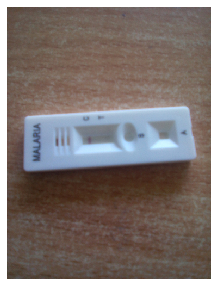

In [8]:
img_f = fnames[1]
img = PILImage.create(img_f)
img.show(figsize=(5,5))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

In [10]:
def get_msk(fn):
  fn = path_lbl/f'{fn.stem}.png'
  msk = np.array(PILMask.create(fn))
  msk[msk > 2] = 0
  return PILMask.create(msk)

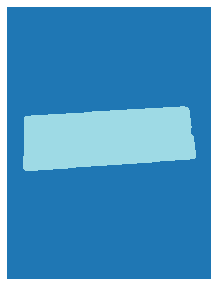

In [11]:
mask = get_msk(img_f)
mask.show(figsize=(5,5), alpha=1)

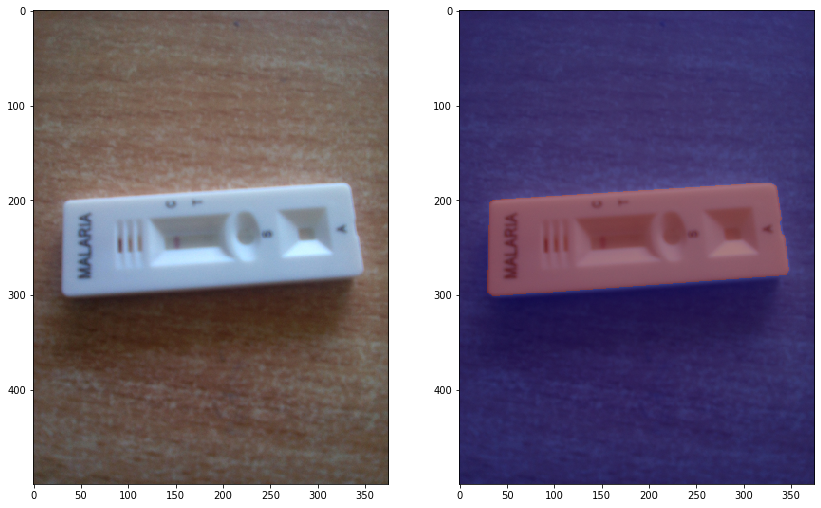

In [12]:
plt.figure(figsize=(14,14))
plt.subplot(1,2,1)
plt.imshow(img, 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(img, 'gray', interpolation='none')
plt.imshow(mask, 'jet', interpolation='none', alpha=0.5)
plt.show()


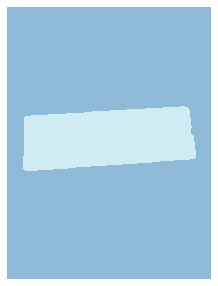

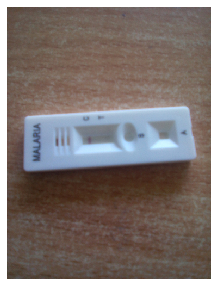

In [13]:
mask = PILMask.create(get_msk(img_f))
mask.show(figsize=(5,5), alpha=.5)
img.show(figsize=(5,5))

In [14]:
src_size = np.array(mask.shape[1:])
src_size,tensor(mask)

(array([375]), tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8))

In [15]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['background', 'carestart'], dtype='<U10')

## Datasets

In [29]:
size = src_size
bs=2

In [30]:
size

array([375])

In [31]:
valid_fnames = lbl_names[20:]#(path/'valid.txt').read().split('\n')

In [32]:
# export
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

In [33]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=lambda o: path/'labels'/f'{o.stem}.png',
                   batch_tfms=[*aug_transforms(size=(187,250)), Normalize.from_stats(*imagenet_stats)])

In [34]:
dls = camvid.dataloaders(path, bs=2, path=path)

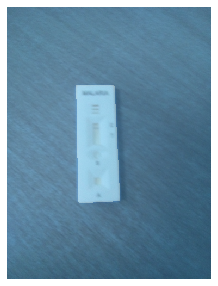

In [35]:
show_at(dls.train_ds, 0)

In [36]:
b = dls.train.one_batch()

In [37]:
b = dls.train.decode(b)

In [38]:
b[0].shape, b[1].shape

(torch.Size([2, 3, 187, 250]), torch.Size([2, 187, 250]))

In [39]:
dls.show_batch(max_n=4, figsize=(20,14))

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 500 and 375 in dimension 2 at /pytorch/aten/src/TH/generic/THTensor.cpp:612

## Model

In [27]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

KeyError: 'Void'

In [28]:
metrics=acc_camvid
# metrics=accuracy

NameError: name 'acc_camvid' is not defined

In [24]:
wd=1e-2

In [25]:
dls.vocab = codes

In [26]:
learn = unet_learner(dls, resnet34, metrics=metrics)

In [27]:
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [28]:
learn.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 524.00 MiB (GPU 0; 7.44 GiB total capacity; 6.07 GiB already allocated; 438.50 MiB free; 6.56 GiB reserved in total by PyTorch)

In [ ]:
lr=3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9, wd=wd)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.show_results(max_n=4, figsize=(9,4))

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8, wd=wd)

In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
del learn

In [ ]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
dls = camvid.dataloaders(path/"images", bs=3, path=path,
                          batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls.vocab = codes

In [ ]:
learn = unet_learner(dls, resnet34, metrics=metrics)

In [ ]:
learn.load('stage-2');

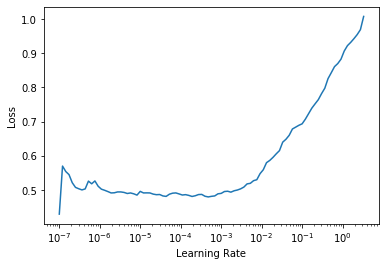

In [ ]:
learn.lr_find()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.434103,0.349006,0.919233,02:28
1,0.416209,0.321492,0.926268,02:27
2,0.374841,0.323334,0.928009,02:30
3,0.373591,0.308711,0.925487,02:30
4,0.354073,0.316937,0.921483,02:29
5,0.333428,0.276603,0.931216,02:28
6,0.343322,0.272028,0.929693,02:28
7,0.313607,0.280513,0.929877,02:28
8,0.278676,0.250869,0.932883,02:29
9,0.236350,0.244575,0.935206,02:28


In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.223516,0.246427,0.936520,02:30
1,0.237247,0.255016,0.935370,02:39
2,0.225134,0.239316,0.936160,02:44
3,0.222252,0.244599,0.936024,02:43
4,0.216221,0.246634,0.935405,02:42
5,0.223981,0.243209,0.935413,02:42
6,0.206087,0.249986,0.934875,02:42
7,0.201352,0.239749,0.936708,02:41
8,0.201420,0.243662,0.936199,02:41
9,0.201602,0.244807,0.936131,02:41


In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

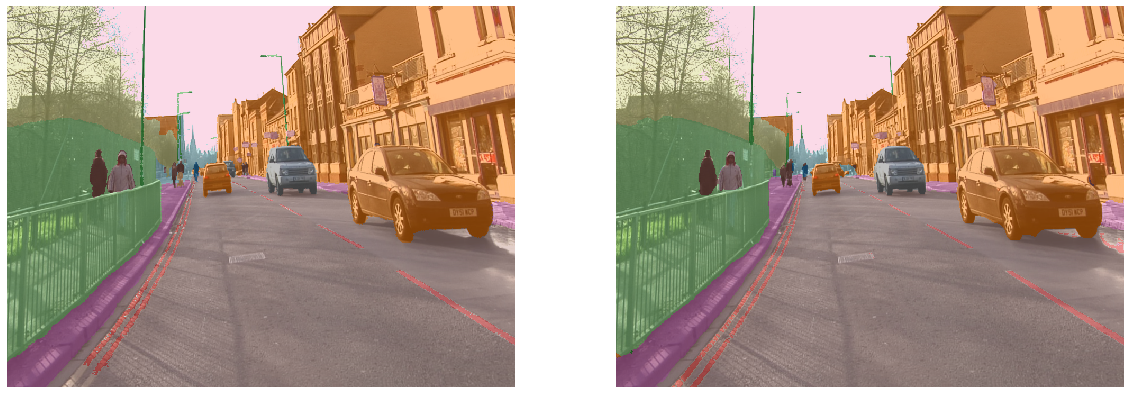

In [ ]:
learn.show_results(max_n=1, figsize=(20,10), vmin=1, vmax=30)

## fin